In [75]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EVA4

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/EVA4


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import json
from skimage import io
from tqdm.notebook import tqdm, trange
path = "./dogs/"
annotations = json.load(open('Annotations.json'))

In [0]:
sizedict = {}
for filename in os.listdir(path):
  image = io.imread(f'{path}{filename}', as_gray=False, pilmode="RGB")
  sizedict[filename] = image.shape[:2]
  
#df = pd.DataFrame.from_dict(json_normalize(annotations), orient='columns')
#df = pd.io.json.json_normalize(annotations)
#df = pd.DataFrame.from_dict(json_normalize(annotations['img_1.jfif4462']), orient='columns')
#annotations.keys()
#json_normalize(raw, [['_source', 'filename']])
#df.columns = df.columns.map(lambda x: x.split(".")[-1])
#df = df.pivot_table(df)
#annotations.items()


#Converting json file to dataframe

In [78]:

df = pd.DataFrame()
dataset = []
for k, v in annotations.items():
  for r in v['regions']:
    fn = {'name': v['filename']}
    shape = r['shape_attributes']
    h, w = sizedict[v['filename']]
    fn['image_w'] = w
    fn['image_h'] = h
    fn['height'] = shape['height']/h
    fn['width'] = shape['width']/w
    fn['log_height'] = math.log(fn['height']/h)
    fn['log_width'] = math.log(fn['width']/h)
    dataset.append(fn)

df = pd.DataFrame.from_dict(dataset, orient='columns')
df.head()



,name,image_w,image_h,height,width,log_height,log_width
0,img_1.jfif,349,144,0.951389,0.555874,-5.019646,-5.557027
1,img_2.jfif,290,174,0.977011,0.341379,-5.182312,-6.233816
2,img_3.jfif,300,168,0.827381,0.430000,-5.313454,-5.967934
3,img_4.jfif,300,168,0.648810,0.393333,-5.556580,-6.057062
4,img_5.jpg,1080,675,0.782222,0.651852,-6.760329,-6.942651


Text(0, 0.5, 'height')

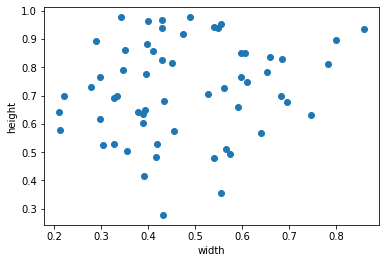

In [79]:
plt.scatter(df.width, df.height)
plt.xlabel('width')
plt.ylabel('height')


Text(0, 0.5, 'log(height)')

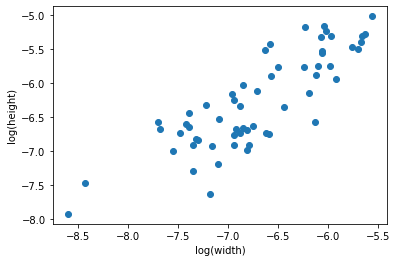

In [80]:
plt.scatter(df.log_width, df.log_height)
plt.xlabel('log(width)')
plt.ylabel('log(height)')

In [0]:
from sklearn.cluster import KMeans

X = df[['width', 'height']].to_numpy()

#KMeans for the annotated dataset

In [0]:
class KMeans:
    """K-Means clustering algorithm."""

    def __init__(self, num_clusters, points, iterations):
        """Initialize parameters of the algorithm.

        Args:
            num_clusters (int): Number of clusters to
                segment the data into.
            points (numpy.ndarray): Points in the dataset.
            iterations (int): Number of iterations for
                running the algorithm.
        """
        self.num_clusters = num_clusters
        self.points = points
        self.iterations = iterations

        self.centroids = self.initialize_centroids()
        self.closest = None
        self.mean_iou = None

        self.find_clusters()
        self.iou()

    def initialize_centroids(self):
        """Select random inital centroids from the points.
        
        Returns:
            Array containing initial centroids.
        """
        centroids = self.points.copy()
        np.random.shuffle(centroids)
        return centroids[:self.num_clusters]

    def closest_centroid(self):
        """Find the closest centroid for each point in the dataset."""
        distances = np.sqrt(
            ((self.points - self.centroids[:, np.newaxis]) ** 2).sum(axis=2)
        )
        self.closest = np.argmin(distances, axis=0)

    def move_centroids(self):
        """Find new centroids based on the points in the cluser."""
        self.centroids =  np.array([
            self.points[self.closest == k].mean(axis=0)
            for k in range(self.centroids.shape[0])
        ])
    
    def find_clusters(self):
        """Run the K-Means algorithm."""
        for _ in range(self.iterations):
            self.closest_centroid()
            self.move_centroids()
    
    def iou(self):
        """Calculate Intersection over Union (IoU) for each point
        with its closest centroid."""
        closest_centroids = self.centroids[self.closest]
        width = np.minimum(
            closest_centroids[:, 0], self.points[:, 0]
        )
        height = np.minimum(
            closest_centroids[:, 1], self.points[:, 1]
        )

        intersection = width * height
        points_area = self.points[:, 0] * self.points[:, 1]
        cluster_area = closest_centroids[:, 0] * closest_centroids[:, 1]

        self.mean_iou = np.mean(
            intersection / (points_area + cluster_area - intersection)
        )
        

In [0]:
iou_list = []
kmeans_model = {}

# Range of number of clusters to try out
num_clusters_start = 1
num_clusters_end = 16

# Number of iterations to run each pass
iterations = 300
# Run K-Means for each range of number of clusters
for k in range(num_clusters_start, num_clusters_end + 1):
    kmeans_model[k + 1] = KMeans(k + 1, X, iterations)
    iou_list.append(kmeans_model[k + 1].mean_iou)

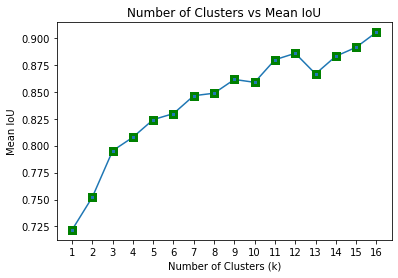

In [94]:
#fig = plt.figure(figsize=(9, 5))
def display_clusters(kmeans):
    num_clusters = kmeans.num_clusters

    # Plot points for each cluster
    for cluster_id in range(num_clusters):
        points = kmeans.points[kmeans.closest == cluster_id]
        plt.scatter(points[:, 0], points[:, 1])
    
    # Plot centroids
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='black', s=90, marker='x')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title(f'Cluster Plot for k = {num_clusters}')

    # Save figure
    plt.savefig(f'cluster_plot_k{num_clusters}.png')
_ = plt.plot(iou_list, '-s', markeredgecolor='green', markeredgewidth=3)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Mean IoU')

plt.xticks(np.arange(len(iou_list)), np.arange(1, len(iou_list)+1))
plt.title('Number of Clusters vs Mean IoU')
fig.savefig('kmeans iou.png')

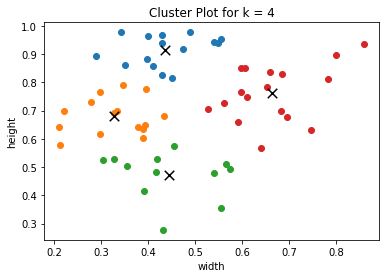

In [95]:
display_clusters(kmeans_model[4])